In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip3 install -q -U accelerate==0.27.1
!pip3 install -q -U transformers==4.38.0
!pip3 install -q -U datasets
!pip3 install -q -U nltk
!pip3 install -q -U rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.7/279.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
file_path = './drive/MyDrive/Colab Notebooks/'

In [51]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM
# model_id = file_path + "bank-chatbot-merged-model"
model_id = "YeyanXXX/bank-chatbot-merged-model"
# model_id = "google/gemma-2b-it"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, device_map='cuda')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [52]:
model.config

GemmaConfig {
  "_name_or_path": "YeyanXXX/bank-chatbot-merged-model",
  "architectures": [
    "GemmaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 2,
  "eos_token_id": 1,
  "head_dim": 256,
  "hidden_act": "gelu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 16384,
  "max_position_embeddings": 8192,
  "model_type": "gemma",
  "num_attention_heads": 8,
  "num_hidden_layers": 18,
  "num_key_value_heads": 1,
  "pad_token_id": 0,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "torch_dtype": "float16",
  "transformers_version": "4.38.0",
  "use_cache": true,
  "vocab_size": 256000
}

In [35]:
def get_completion(query: str, model, tokenizer) -> str:
  device = "cuda"
  prompt_template = """
  <start_of_turn>user
  {query}
  <end_of_turn>\\n<start_of_turn>model

  """
  prompt = prompt_template.format(query=query)
  encodeds = tokenizer(prompt, return_tensors="pt", add_special_tokens=True)
  model_inputs = encodeds.to(device)
  generated_ids = model.generate(**model_inputs, max_new_tokens=1000, do_sample=True, pad_token_id=tokenizer.eos_token_id)
  # decoded = tokenizer.batch_decode(generated_ids)
  decoded = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
  return (decoded)



In [53]:
query = "What is the time frame to report Debit Card transaction dispute"
result = get_completion(query=query, model=model, tokenizer=tokenizer)
pattern = r'model[\s\S]*'
# 使用正则表达式查找并获取匹配的内容
match = re.search(pattern, result)

if match:
  result = match.group(0)
    # 去掉'model'本身，只保留其后面的内容
  ivr_steps = result.replace('model', '').strip()
  print(ivr_steps)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


lossom 鈥？nday to 鈥?ce of all days when the Debit Card is found to be lost or abused, the Merchant is required to reverse the Credit Card transaction i.e. the money from the Merchant's account to yours. If 鈥?s not done, the Debit Card can be sent to the Fraud squad of the issuing Bank for a review. \nThe Merchant has to reverse the Credit Card transaction and refund the exact amount of money, without any cash collection for a disputed product being sold. \nThe customer can raise a dispute in writing to the concerned merchant at the time of purchase of his Debit Card. \nOnce a written claim is made, the authority is vested to review the validity of the said claim and render the necessary approval. 鈥?s the Merchant found to be in the wrong for any reason, the company will reimburse the amount to the cardholder. 鈥?s the Merchant is not found to be in the wrong for any reason, the company will reimburse the amount to the Merchant and also refund the excess money collected from the cardholde

In [8]:
from datasets import Dataset, load_dataset
import pandas as pd
import re
import nltk
import numpy as np
from nltk.translate.bleu_score import sentence_bleu

In [48]:
df = pd.read_csv(file_path + 'train_set.csv')
dataset = Dataset.from_pandas(df)
dataset.shuffle(seed=4321)
dataset = dataset[:103]
dataset['Question'][0]

'What is the time frame to report Debit Card transaction dispute'

In [49]:
dataset['Answer'][0]

'Transaction dispute needs to be reported in writing within 30 days from the transaction date.'

In [37]:
querys = dataset['Question']
answers = dataset['Answer']

In [23]:
from rouge_score import rouge_scorer
def sentence_rouge(reference, candidate):
  # 假设我们有两个字符串，一个是生成的文本摘要，另一个是参考文本摘要
  generated_summary = candidate
  reference_summary = reference

  # 初始化Scorer实例
  scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

  # 计算得分
  scores = scorer.score(generated_summary, reference_summary)
  # 返回字典
  return scores
# 输出ROUGE-1, ROUGE-2, 和 ROUGE-L的F1分数


In [43]:
sentence_rouge('Iaf havae ga dogd, itcd iss cute', 'I have a cat, it is cuqte')

{'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0),
 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0),
 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}

In [38]:
BLEU_gemma = []
ROUGE1_gemma = []
ROUGE2_gemma = []
ROUGEL_gemma = []
for i in range(len(querys)):
  print(i)
  result = get_completion(query=querys[i], model=model, tokenizer=tokenizer)
  pattern = r'model[\s\S]*'

  # 使用正则表达式查找并获取匹配的内容
  match = re.search(pattern, result)

  if match:
    result = match.group(0)
      # 去掉'model'本身，只保留其后面的内容
    ivr_steps = result.replace('model', '').strip()
    # print(ivr_steps)

    reference = [answers[i].split()]
    candidate = ivr_steps.split()
    bleu_score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
    scores = sentence_rouge(answers[i], ivr_steps)

    BLEU_gemma.append(bleu_score)
    ROUGE1_gemma.append(scores['rouge1'].fmeasure)
    ROUGE2_gemma.append(scores['rouge2'].fmeasure)
    ROUGEL_gemma.append(scores['rougeL'].fmeasure)
BLEU_original_model = np.mean(BLEU_gemma)
ROUGE1_original_model = np.mean(ROUGE1_gemma)
ROUGE2_original_model = np.mean(ROUGE2_gemma)
ROUGEL_original_model = np.mean(ROUGEL_gemma)
print('BLEU:',BLEU_original_model,
   '\nROUGE1:',ROUGE1_original_model,
   '\nROUGE2:',ROUGE2_original_model,
   '\nROUGEL:',ROUGEL_original_model)

0


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


1
2
3
4


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
BLEU: 0.009725251813783678 
ROUGE1: 0.22983082606148533 
ROUGE2: 0.05843928367245067 
ROUGEL: 0.1484156679821411


In [27]:
BLEU_bank_chatbot = []
ROUGE1_bank_chatbot = []
ROUGE2_bank_chatbot = []
ROUGEL_bank_chatbot = []
for i in range(len(querys)):
  print(i)
  result = get_completion(query=querys[i], model=model, tokenizer=tokenizer)
  pattern = r'model[\s\S]*'

  # 使用正则表达式查找并获取匹配的内容
  match = re.search(pattern, result)

  if match:
    result = match.group(0)
      # 去掉'model'本身，只保留其后面的内容
    ivr_steps = result.replace('model', '').strip()
    # print(ivr_steps)

    reference = [answers[i].split()]
    candidate = ivr_steps.split()
    bleu_score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
    scores = sentence_rouge(answers[i], ivr_steps)

    BLEU_bank_chatbot.append(bleu_score)
    ROUGE1_bank_chatbot.append(scores['rouge1'].fmeasure)
    ROUGE2_bank_chatbot.append(scores['rouge2'].fmeasure)
    ROUGEL_bank_chatbot.append(scores['rougeL'].fmeasure)
BLEU_merged_model = np.mean(BLEU_bank_chatbot)
ROUGE1_merged_model = np.mean(ROUGE1_bank_chatbot)
ROUGE2_merged_model = np.mean(ROUGE2_bank_chatbot)
ROUGEL_merged_model = np.mean(ROUGEL_bank_chatbot)
print('BLEU:',BLEU_merged_model,
   '\nROUGE1:',ROUGE1_merged_model,
   '\nROUGE2:',ROUGE2_merged_model,
   '\nROUGEL:',ROUGEL_merged_model)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


0


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


1


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


2


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


3


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


4


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


5


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


6


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


7


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


8


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


9


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


10


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


11


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


12


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


13


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


14


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


15


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


16


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


17


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


18


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


19


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


20


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


21


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


22


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


23


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


24


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


25


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


26


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


27


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


28


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


29


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


30


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


31


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


32


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


33


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


34


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


35


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


36


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


37


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


38


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


39


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


40


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


41


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


42


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


43


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


44


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


45


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


46


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


47


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


48


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


49


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


50


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


51


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


52


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


53


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


54


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


55


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


56


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


57


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


58


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


59


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


60


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


61


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


62


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


63


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


64


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


65


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


66


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


67


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


68


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


69


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


70


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


71


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


72


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


73


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


74


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


75


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


76


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


77


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


78


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


79


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


80


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


81


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


82


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


83


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


84


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


85


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


86


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


87


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


88


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


89


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


90


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


91


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


92


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


93


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


94


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


95


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


96


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


97


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


98


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


99


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


100


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


101


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


102


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


103


KeyboardInterrupt: 

In [28]:
BLEU_merged_model = np.mean(BLEU_bank_chatbot)
ROUGE1_merged_model = np.mean(ROUGE1_bank_chatbot)
ROUGE2_merged_model = np.mean(ROUGE2_bank_chatbot)
ROUGEL_merged_model = np.mean(ROUGEL_bank_chatbot)
print('BLEU:',BLEU_merged_model,
   '\nROUGE1:',ROUGE1_merged_model,
   '\nROUGE2:',ROUGE2_merged_model,
   '\nROUGEL:',ROUGEL_merged_model)

BLEU: 0.004169024615889749 
ROUGE1: 0.1477298327214734 
ROUGE2: 0.03781535324784406 
ROUGEL: 0.08945045531352358


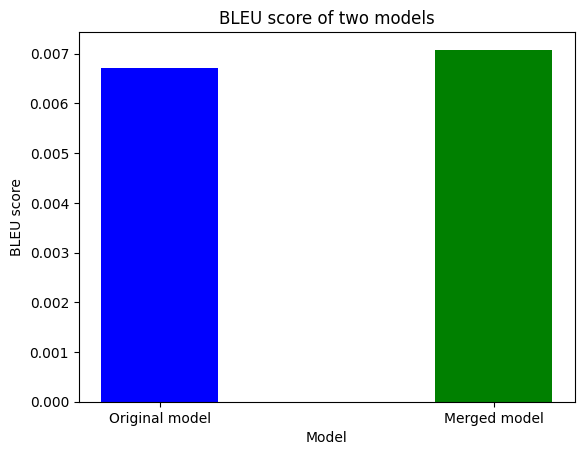

In [ ]:
import matplotlib.pyplot as plt
# 创建数据列表
data = [BLEU_original_model, BLEU_merged_model]

# 创建对应的类别标签（如果有类别的话，否则可以用任意标签或者索引）
labels = ['Original model', 'Merged model']

# 设置柱状图宽度（可调整）
bar_width = 0.35

# 创建柱状图
plt.bar(labels, data, width=bar_width, color=['b', 'g'])

# 设置坐标轴标签和标题
plt.xlabel('Model')
plt.ylabel('BLEU score')
plt.title('BLEU score of two models')

# 显示图形
plt.show()